In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from pathlib import Path
import pandas as pd
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
from scipy.ndimage import gaussian_filter1d



In [2]:
# base_dir = r'C:\Users\srini\Documents\GitHub\Paton-Lab--Summer-2024\Splinter' # Champalimaud PC dir

base_dir = r'/Users/srinidhienaidu/Downloads/GitHub/Paton-Lab--Summer-2024/Splinter' # Srinidhi Mac dir
session = 0 # Change based on which trial you want
date = sorted(os.listdir(base_dir))[session + 1]
path = os.path.join(base_dir, date)
os.chdir(path)
print(path)

log_df = pd.read_csv('LogDf.csv')
session_df = pd.read_csv('SessionDf.csv')

log_data = log_df.to_dict(orient= 'dict')
session_data = session_df.to_dict(orient= 'dict')

spike_times = np.load('spiketimes.npy', allow_pickle=True)
NUM_NEURONS = spike_times.shape[0]
NUM_STIMS = 8

/Users/srinidhienaidu/Downloads/GitHub/Paton-Lab--Summer-2024/Splinter/2016-07-27


In [3]:
print('Date: ', sorted(os.listdir(base_dir))[session + 1])
print('Number Neurons: ', NUM_NEURONS)
print('Log Keys: ', log_data.keys())
print('Session Keys: ', session_data.keys())

Date:  2016-07-27
Number Neurons:  19
Log Keys:  dict_keys(['Unnamed: 0', 't', 'name', 'var', 'value'])
Session Keys:  dict_keys(['Unnamed: 0', 'chosen_side', 'chosen_interval', 'correct_side', 'interval_category', 'has_choice', 'this_interval', 'outcome', 'init_port', 'choice_rt', 't_on', 't_off', 't'])


In [4]:
def remove_nans(arr):
    return [x for x in arr if not math.isnan(x)]

def nan_idx(data):
    nan_idx = []
    for index in data:
        if isinstance(data[index], float):
            nan_idx.append(index)
    return nan_idx

for cell in range(NUM_NEURONS):
    spike_times[cell] = remove_nans(spike_times[cell])  

In [5]:
stim_onset_t_pre = []
stim_offset_t = []

for index in range(len(log_data['t'])):

    time = log_data['t'][index]
    name = log_data['name'][index]

    if name == 'STIM_ONSET_EVENT':
        stim_onset_t_pre.append(time)
    elif name == 'STIM_OFFSET_EVENT':
        stim_offset_t.append(time)  
    
NUM_TRIALS = len(stim_offset_t)
trial_num = np.arange(0, len(stim_onset_t_pre), 1)

code for plotting raw rasters, before sorting by stim_duration

In [6]:
# window = [-2000,4000]
# n_trials = len(stim_onset_t)
# neuron = 13
# all_spikes_neuron = []
# all_trial_nums = []
# for idx, trial in enumerate(original_indices):
#     # print(trial)
#     # print(stim_onset_t[trial])
#     aligned_spikes = np.array(spike_times[neuron]) - stim_onset_t[trial]
#     # print(aligned_spikes)
#     trial_index_spikes = np.intersect1d(np.where(aligned_spikes<window[1])[0],np.where(aligned_spikes>window[0])[0])
#     all_spikes_neuron.extend(aligned_spikes[trial_index_spikes])
#     n_spikes = len(trial_index_spikes)
#     all_trial_nums.extend([trial]*n_spikes)
# print(all_trial_nums)
# plt.figure()
# plt.scatter(all_spikes_neuron, all_trial_nums,s=0.1)
# plt.ylabel("Trial number")
# plt.xlabel("Time since stimulus onset (ms)")
# plt.title(f"Neuron {neuron}")
# plt.axvline(x=0,color="k",ls="--")
# plt.show()

In [11]:
choice = session_data['chosen_side']
no_choice_idx = nan_idx(choice)

stim_onset_t = [value for index, value in enumerate(stim_onset_t_pre) if index not in no_choice_idx]
og_trial_num = [value for index, value in enumerate(trial_num) if index not in no_choice_idx]

general_trial_num = np.arange(0, len(stim_onset_t), 1)

int_durations = np.zeros((NUM_TRIALS))
choice_rt = []

for idx, val in enumerate(og_trial_num):

    int_durations[idx] = (session_data['this_interval'][val])
    choice_rt.append(session_data['choice_rt'][val])


sort_by_dur_idx = np.argsort(int_durations)

sorted_int_durations = int_durations[sort_by_dur_idx]
new_sorted_trials = general_trial_num[sort_by_dur_idx]

dur_vals = [600, 1050, 1260, 1380, 1620, 1740, 1950, 2400]

In [12]:
def list_to_sorted_arr(og_list):
    arr = np.array(og_list)
    return arr[sort_by_dur_idx]

Neuron  0
Neuron  1


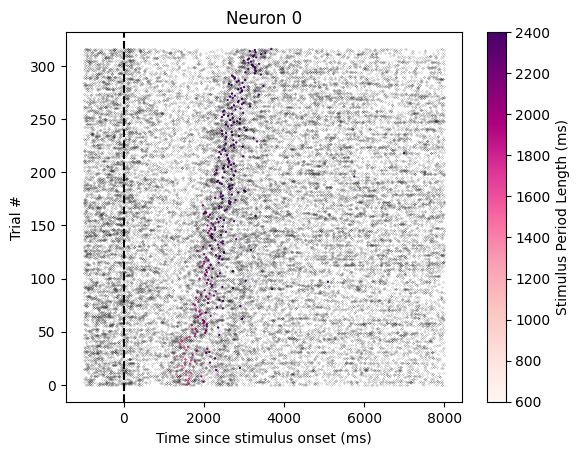

<Figure size 640x480 with 0 Axes>

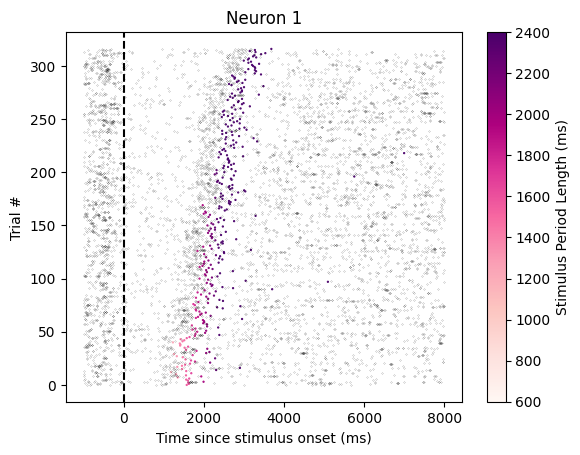

<Figure size 640x480 with 0 Axes>

In [13]:
data = stim_onset_t
data_points = choice_rt
BIN_SIZE = 100

window = [-1000, 8000]

cmap = plt.get_cmap('RdPu')
norm = mcolors.Normalize(vmin=600, vmax=2400)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for neuron in range(2):
    bins = np.arange(window[0], window[1], BIN_SIZE)
    spike_counts = np.zeros((NUM_STIMS, bins.shape[0]))
    count = 0

    all_spikes_neuron = []
    all_trial_nums = []
    num_spikes = []
    
    points = np.array(list_to_sorted_arr(stim_offset_t) + list_to_sorted_arr(choice_rt) - list_to_sorted_arr(stim_onset_t))
    colors = cmap(norm(points))

    for idx, val in enumerate(new_sorted_trials):
        aligned_spikes = np.array(spike_times[neuron]) - data[val]
        trial_index_spikes = np.intersect1d(np.where(aligned_spikes < window[1])[0], np.where(aligned_spikes > window[0])[0])
        all_spikes_neuron.extend(aligned_spikes[trial_index_spikes])
        n_spikes = len(trial_index_spikes)
        all_trial_nums.extend([idx] * n_spikes)

    fig, ax = plt.subplots()

    print('Neuron ', neuron)
    plt.figure()
    ax.scatter(points, range(NUM_TRIALS), s=0.4, color=colors)  # Use calculated colors

    ax.scatter(all_spikes_neuron, all_trial_nums, s=0.01, color='k')

    ax.set_ylabel("Trial #")
    ax.set_xlabel(f"Time since stimulus {'onset'} (ms)")
    ax.set_title(f"Neuron {neuron}")
    ax.axvline(x=0, color="k", ls="--")

    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Stimulus Period Length (ms)')

plt.show()


In [ ]:
int_counts = Counter(sorted_int_durations)
counts = list(int_counts.values())

cumulative_sum_list = [0]
running_total = 0
for value in counts:
    running_total += value
    cumulative_sum_list.append(running_total)

cmap = plt.get_cmap('RdPu')
points = np.linspace(0, 1, NUM_STIMS + 1)
colors = []
for stim in range(NUM_STIMS):
    colors.append(cmap(points[stim + 1]))


In [ ]:
BIN_SIZE = 100

for neuron in range(NUM_NEURONS):
    test = []
    window = [-1000, 4000]
    bins = np.arange(window[0], window[1], BIN_SIZE)
    spike_counts = np.zeros((NUM_STIMS, bins.shape[0]))

    for idx, val  in enumerate(new_sorted_trials):
        aligned_spikes = np.array(spike_times[neuron]) - data[val]
        trial_index_spikes = np.intersect1d(np.where(aligned_spikes<window[1])[0],np.where(aligned_spikes>window[0])[0])
        test.append([aligned_spikes[trial_index_spikes]])

    for val in range(NUM_STIMS):
        start_idx = cumulative_sum_list[val]
        end_idx = cumulative_sum_list[val + 1]
        for trial in range(NUM_TRIALS):
            if start_idx <= trial < end_idx:
                row = val

                for index, bin in enumerate(bins):

                    start = bins[index]
                    end = start + BIN_SIZE
                    for spike in test[trial][0]:
                        if start <= spike < end:
                            spike_counts[row][index] += 1
        sigma = 1
        filtered = gaussian_filter1d(spike_counts[val], sigma)
        plt.plot(filtered, color = colors[val])
        plt.ylabel('Firing Rate')
        plt.title(f'Neuron {neuron}')

    plt.figure()


In [ ]:
data = stim_offset_t
data_points = choice_rt

for neuron in range(NUM_NEURONS):   
    window = [-1000,8000]
    all_spikes_neuron = []
    all_trial_nums = []
    
    points = list_to_sorted_arr(choice_rt) 
    
    for idx, val in enumerate(new_sorted_trials):
        aligned_spikes = np.array(spike_times[neuron]) - data[val]
        trial_index_spikes = np.intersect1d(np.where(aligned_spikes<window[1])[0],np.where(aligned_spikes>window[0])[0])
        all_spikes_neuron.extend(aligned_spikes[trial_index_spikes])
        n_spikes = len(trial_index_spikes)
        all_trial_nums.extend([idx]*n_spikes)

    fix, ax = plt.subplots()

    plt.scatter(points, range(NUM_TRIALS), s = 0.4, color = 'b')

    ax.scatter(all_spikes_neuron, all_trial_nums,s=0.01, color = 'k')

    ax.set_ylabel("Trial #")
    ax.set_xlabel(f"Time since stimulus {'onset'} (ms)")
    ax.set_title(f"Neuron {neuron}")
    ax.axvline(x=0,color="k",ls="--")


    cmap = plt.get_cmap('bone')
    norm = mcolors.Normalize(vmin = 600, vmax = 2400)
    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax = ax)
    cbar.set_label('Stimulus Period Length (ms)')